<a href="https://colab.research.google.com/github/martynakol/UM-w-finansach/blob/main/aktywnosc_UM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip3 install ta

Strategia 1

[*********************100%%**********************]  101 of 101 completed


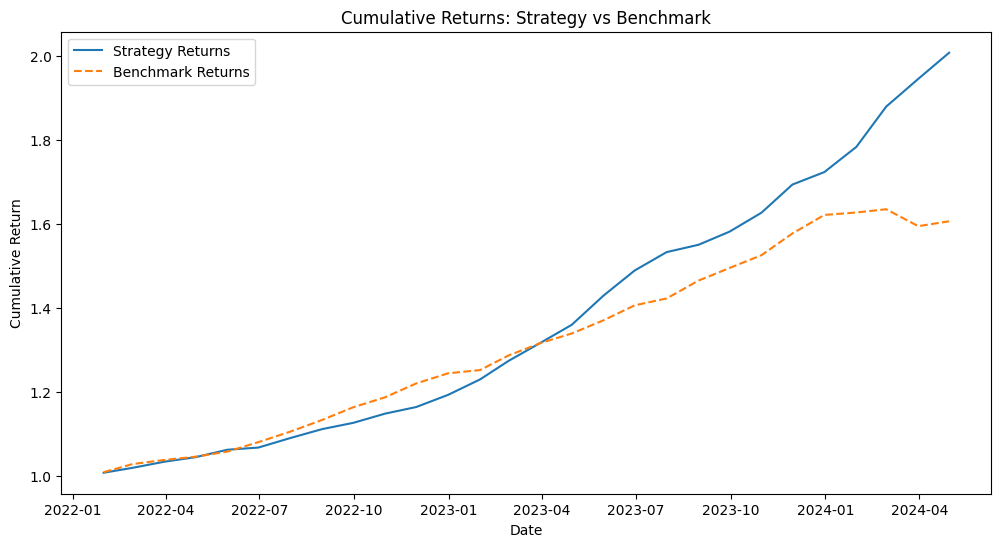

In [49]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import random


tickers = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
symbols = tickers['Ticker'].to_list()


df = yf.download(symbols, start='2022-01-01')['Adj Close']


df.dropna(axis=1, inplace=True)
df = (df.pct_change() + 1)[1:].resample("M").prod()


def get_rtn(df, n):
    return df.rolling(n).apply(np.prod)

def get_top(date, df):
    r12 = get_rtn(df, 12)
    r6 = get_rtn(df, 6)
    r3 = get_rtn(df, 3)
    top50 = r12.loc[date].nlargest(50).index
    top30 = r6.loc[date, top50].nlargest(30).index
    top10 = r3.loc[date, top30].nlargest(10).index
    return top10

def get_random(date, df):
    numbers = [random.randint(0, df.shape[1]-1) for i in range(10)]
    names = df.columns[numbers]
    return df.loc[date:, names]

def portfolio_res(date, df):
    return df.loc[date:, get_top(date, df)].mean(axis=1)

def portfolio_res_random(date, df):
    return df.loc[date:, get_random(date, df).columns].mean(axis=1)


dates = df.index[:-1]
strategy_returns = []
for d in dates:
    strategy_returns.append(portfolio_res(d, df).mean())


benchmark_returns = []
for d in dates:
    benchmark_returns.append(portfolio_res_random(d, df).mean())


plt.figure(figsize=(12, 6))
plt.plot(dates, pd.Series(strategy_returns).cumprod(), label='Strategy Returns')
plt.plot(dates, pd.Series(benchmark_returns).cumprod(), label='Benchmark Returns', linestyle='--')
plt.legend()
plt.title('Cumulative Returns: Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()


Strategia 2

In [50]:
import pandas as pd
import yfinance as yf
import numpy as np
from collections import Counter
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random


tickers = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
symbols = tickers['Ticker'].to_list()
df = yf.download(symbols, start='2021-01-01', end='2023-12-31')
df.dropna(axis=1, inplace=True)
df = (df['Adj Close'].pct_change() + 1)[1:].resample("M").prod()


def get_rtn(df, n):
    return df.rolling(n).apply(np.prod)

def get_top(date, df):
    r12 = get_rtn(df, 12)
    r6 = get_rtn(df, 6)
    r3 = get_rtn(df, 3)
    top50 = r12.loc[date].nlargest(50).index
    top30 = r6.loc[date, top50].nlargest(30).index
    top10 = r3.loc[date, top30].nlargest(10).index
    return top10


dates = df.index[:-1]
top_stocks = []
for d in dates:
    top_stocks.extend(get_top(d, df))


stock_counter = Counter(top_stocks)
most_common_stocks = [stock for stock, count in stock_counter.most_common(3)]
print("Najczęściej występujące akcje:", most_common_stocks)


def generate_technical_indicators(stock):
    stock_data = yf.download(stock, start='2021-01-01', end='2023-12-31')['Adj Close']
    df_ta = pd.DataFrame(index=stock_data.index)
    df_ta['price'] = stock_data
    df_ta['rsi'] = ta.momentum.RSIIndicator(stock_data).rsi()
    df_ta['macd'] = ta.trend.MACD(stock_data).macd()
    df_ta['stochrsi'] = ta.momentum.StochRSIIndicator(stock_data).stochrsi()
    df_ta['roc'] = ta.momentum.ROCIndicator(stock_data).roc()
    df_ta['tsi'] = ta.momentum.TSIIndicator(stock_data).tsi()
    return df_ta


indicators = {stock: generate_technical_indicators(stock) for stock in most_common_stocks}


weights = {
    'class_1': [0.2, 0.2, 0.6],
    'class_2': [0.6, 0.2, 0.2],
    'class_3': [0.2, 0.6, 0.2]
}


data_frames = []
for stock, df_ta in indicators.items():
    df_ta['stock'] = stock
    data_frames.append(df_ta)

data = pd.concat(data_frames)


data['target'] = np.random.choice(['class_1', 'class_2', 'class_3'], size=len(data), p=[0.2, 0.6, 0.2])

X = data.drop(columns=['target', 'stock'])
y = data['target']


X = X.fillna(method='ffill').fillna(method='bfill')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


test_data = yf.download(most_common_stocks, start='2024-01-01')['Adj Close']
test_indicators = {stock: generate_technical_indicators(stock) for stock in most_common_stocks}


predictions = {}
for stock, df_ta in test_indicators.items():
    X_2024 = df_ta.drop(columns=['stock'], errors='ignore')
    X_2024 = X_2024.fillna(method='ffill').fillna(method='bfill')
    predictions[stock] = clf.predict(X_2024)


for stock, pred in predictions.items():
    print(f"Prognozy dla {stock} w 2024 roku: {pred}")


[*********************100%%**********************]  101 of 101 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Najczęściej występujące akcje: ['AVGO', 'CDNS', 'ADP']



[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Prognozy dla AVGO w 2024 roku: ['class_2' 'class_2' 'class_2' 'class_2' 'class_2' 'class_2' 'class_1'
 'class_2' 'class_2' 'class_2' 'class_2' 'class_3' 'class_2' 'class_2'
 'class_2' 'class_1' 'class_3' 'class_2' 'class_2' 'class_2' 'class_2'
 'class_3' 'class_1' 'class_2' 'class_3' 'class_1' 'class_2' 'class_2'
 'class_2' 'class_2' 'class_2' 'class_2' 'class_2' 'class_2' 'class_2'
 'class_2' 'class_2' 'class_3' 'class_3' 'class_2' 'class_3' 'class_1'
 'class_3' 'class_2' 'class_2' 'class_2' 'class_2' 'class_2' 'class_2'
 'class_3' 'class_3' 'class_2' 'class_2' 'class_3' 'class_2' 'class_2'
 'class_2' 'class_3' 'class_1' 'class_2' 'class_1' 'class_2' 'class_2'
 'class_2' 'class_1' 'class_2' 'class_2' 'class_2' 'class_2' 'class_2'
 'class_2' 'class_2' 'class_3' 'class_2' 'class_2' 'class_2' 'class_3'
 'class_3' 'class_3' 'class_2' 'class_3' 'class_1' 'class_3' 'class_2'
 'class_1' 'class_1' 'class_2' 'class_2' 'class_1' 'class_2' 'class_3'
 'class_2' 'class_3' 'class_2' 'class_1' 'clas